# Определение стоимости автомобилей

**Описание данных**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Нам нужно построить модель для определения стоимости автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**\
`date_crawled` — дата скачивания анкеты из базы\
`vehicle_type` — тип автомобильного кузова\
`registration_year` — год регистрации автомобиля\
`gearbox` — тип коробки передач\
`power` — мощность (л. с.)\
`model` — модель автомобиля\
`kilometer` — пробег (км)\
`registration_month` — месяц регистрации автомобиля\
`fuel_type` — тип топлива\
`brand` — марка автомобиля\
`not_repaired` — была машина в ремонте или нет\
`date_created` — дата создания анкеты\
`number_of_pictures` — количество фотографий автомобиля\
`postal_code` — почтовый индекс владельца анкеты (пользователя)\
`last_seen` — дата последней активности пользователя\

**Целевой признак**\
`price` — цена (евро)

## Подготовка данных

In [1]:
import time
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, GridSearchCV, cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Конвертируем "сamelСase" в "snake_case"

In [4]:
columns = []
for i in range(len(df.columns)):
    columns.append(re.sub(r'(?<!^)(?=[A-Z])', '_', df.columns[i]).lower())
df.columns = columns    

In [5]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим максимально возможную дату в данных

In [6]:
df['date_crawled'].max()

'2016-04-07 14:36:58'

Посмотрим уникальные значения столбца `number_of_pictures`

In [7]:
df['number_of_pictures'].unique()

array([0])

так как столбец содержит одно значение "0", удалим данный столбец

In [8]:
df = df.drop(['number_of_pictures'], axis=1)

Посмотри общую информацию о датасете

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


`date_crawled` - можно сменить тип на datetime,\
`not_repaired` - можно заменить на bool,\
`date_created` - можно сменить тип на datetime,\
`last_seen` - можно сменить тип на datetime

Сменим тип данных содержащих дату с "object" на "datetime"

In [10]:
def to_date(date):
    date = pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
    return date

In [11]:
df['date_crawled'] = to_date(df['date_crawled'])
df['date_created'] = to_date(df['date_created'])
df['last_seen'] = to_date(df['last_seen'])

Заменим значения в столбце `not_repaired` c "yes" и "no" на 1 и 0

In [12]:
df['not_repaired'] = df['not_repaired'].map(dict(yes=1, no=0))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  float64       
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

Посмотрим на статистики датасета

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
not_repaired,283215.0,0.127303,0.333312,0.0,0.0,0.0,0.0,1.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


1) Для параметров `price`, `power`, `registration_year` минимальные значения меньше ожидаемых;\
2) Для параметров `power`, `registration_year` максимальные значения больше ожидаемых;\
3) Для параметра  `price` среднее значение в 1.6 раз больше медианного, что может свидетельствовать о выбросах.

Рассмотрим "выбивающиеся" параметры подробнее

Посмотрим на целевой признак `price`

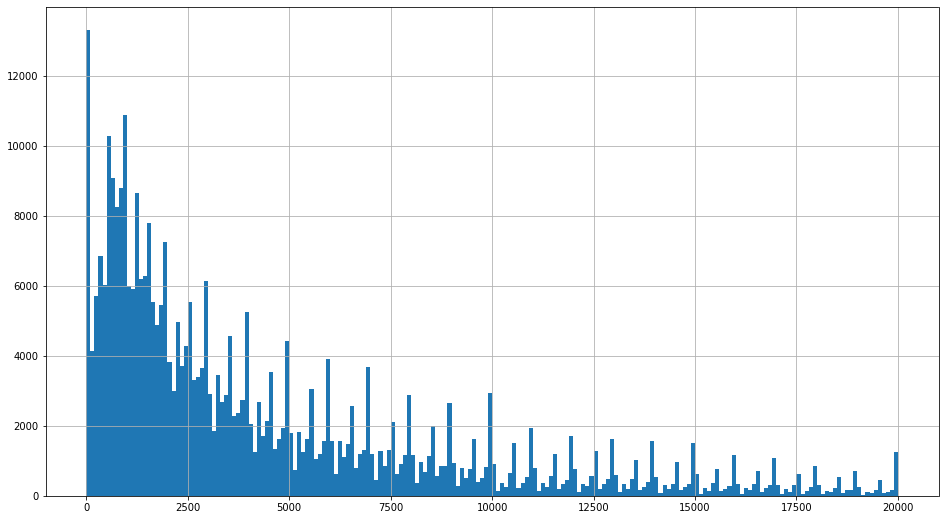

In [15]:
df['price'].hist(bins=200, figsize=(16,9));

Заметно большое количество объявлений с ценой 0 и небольшое увеличение объявлений с ценой 20 000

In [16]:
df[df['price'] == 0].count()

date_crawled          10772
price                 10772
vehicle_type           7032
registration_year     10772
gearbox                8294
power                 10772
model                  8588
kilometer             10772
registration_month    10772
fuel_type              7336
brand                 10772
not_repaired           5484
date_created          10772
postal_code           10772
last_seen             10772
dtype: int64

Более 10 000 объявлений с ценой 0

Посмотрим значения столбца `power`

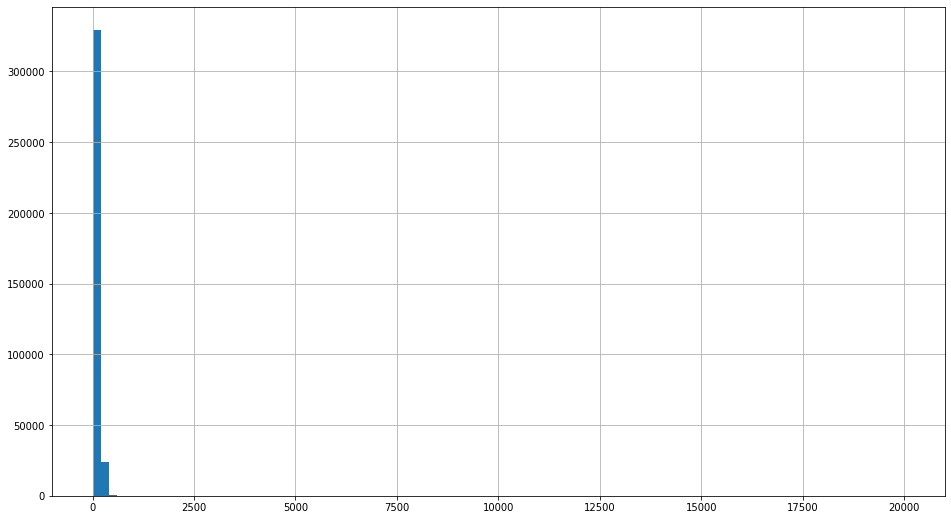

In [17]:
df['power'].hist(bins=100, figsize=(16,9));

Видно, что встречаются не правдоподобно большие значения (более 1000)

Посмотрим на срез столбца `power` с ограничением мощности до 1000

In [18]:
t = df.query('power < 1000')

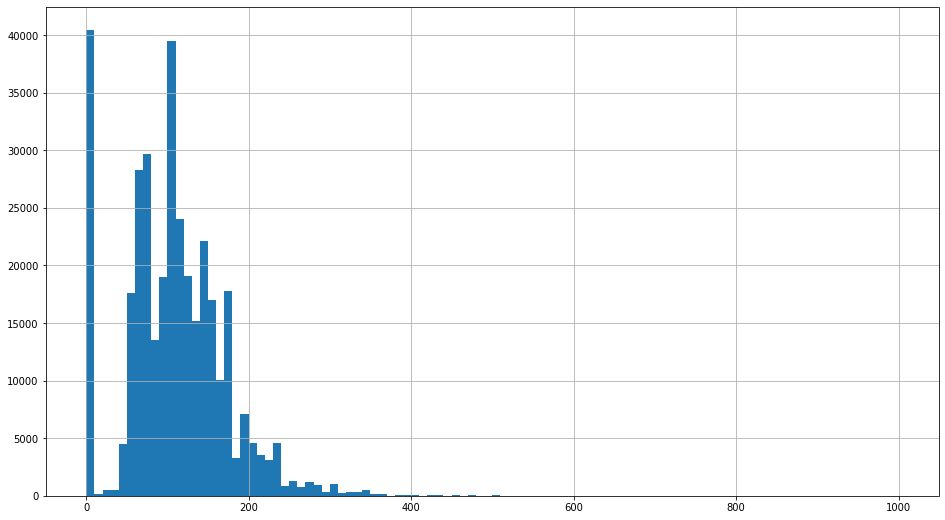

In [19]:
t['power'].hist(bins=100, figsize=(16,9));

Видно, что есть выбросы с мощностью 0, которые тоже можно будет убрать 

Посмотрим на распределение значений в столбце `kilometer`

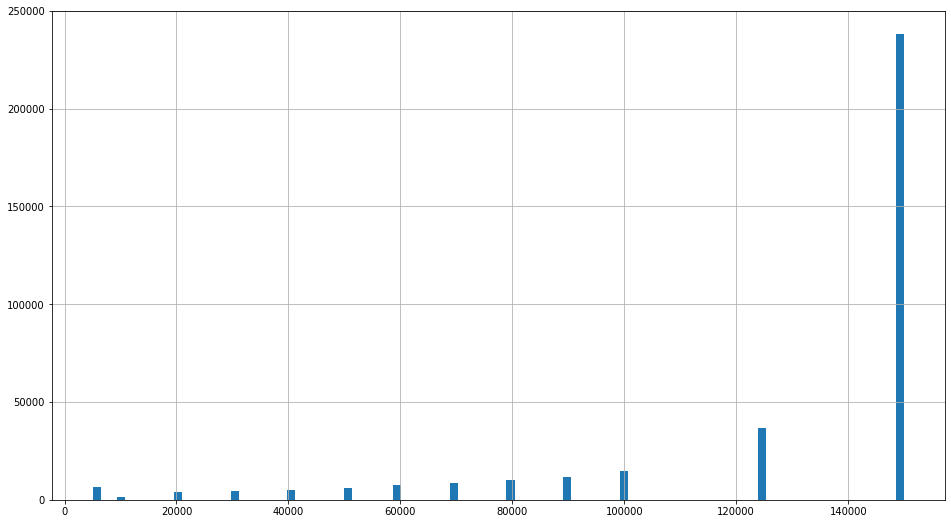

In [20]:
df['kilometer'].hist(bins=100, figsize=(16,9));

In [21]:
df[df['kilometer'] == 150000].count()

date_crawled          238209
price                 238209
vehicle_type          211493
registration_year     238209
gearbox               225358
power                 238209
model                 224951
kilometer             238209
registration_month    238209
fuel_type             214877
brand                 238209
not_repaired          185587
date_created          238209
postal_code           238209
last_seen             238209
dtype: int64

В столбце `kilometer` более 230 000 записей со значением пробега 150 000 км, большинство автомобилей в объявлениях имеет одинаковый пробег

Посмотрим на срез данных без выбросов по цене, мощности и году регистрации

In [22]:
df = df.query(" 0< price < 20000 and 0 < power < 1000 and 1800 < registration_year < 2017")

In [23]:
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1.0,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0.0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0,2016-03-31,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1.0,2016-04-04,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,0.0,2016-03-09,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,1.0,2016-03-19,96465,2016-03-19 20:44:43
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0.0,2016-03-05,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0.0,2016-03-19,87439,2016-04-07 07:15:26


Посмотрим на статистики получившегося среза

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,296390.0,4842.224650,4593.590988,1.0,1340.0,3200.0,6990.0,19999.0
registration_year,296390.0,2002.811198,6.552385,1910.0,1999.0,2003.0,2007.0,2016.0
power,296390.0,120.635511,54.656016,1.0,75.0,110.0,150.0,999.0
kilometer,296390.0,128296.990452,36776.082746,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,296390.0,5.992392,3.584138,0.0,3.0,6.0,9.0,12.0
not_repaired,253424.0,0.114220,0.318078,0.0,0.0,0.0,0.0,1.0
postal_code,296390.0,51237.577820,25781.313201,1067.0,30926.0,50259.0,72108.0,99998.0


Избавившись от выбрасов в крайних значениях мы приблизили медианные значения параметров к средним значениям и избавились от неправдоподобных данных

Определим количество пропусков в данных, %

In [25]:
df.isna().mean().sort_values(ascending=False)*100

not_repaired          14.496441
fuel_type              5.258949
model                  3.776443
vehicle_type           3.728871
gearbox                1.818212
date_crawled           0.000000
price                  0.000000
registration_year      0.000000
power                  0.000000
kilometer              0.000000
registration_month     0.000000
brand                  0.000000
date_created           0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

Посмотрим на распределение данных в столбцах с пропусками

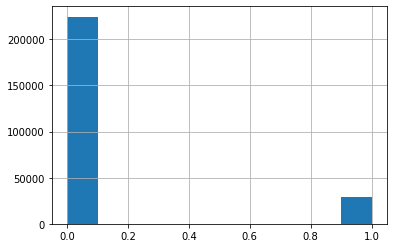

In [26]:
df['not_repaired'].hist();

In [27]:
df['not_repaired'].unique()

array([ 1., nan,  0.])

Определим среднее значение столбца `not_repaired` и заполним пропуски ближайшим целым

In [30]:
df['not_repaired'].mean() 

0.11421964770503189

Значения столбца `not_repaired` близко к 0

Т.к `not_repaired` близок к 0, заполним пропуски "0"

In [31]:
df['not_repaired'] = df['not_repaired'].fillna(0)

Пропусков в столбце `fuel_type` менее 6%, заполним пропуски значением "заглушкой"

In [32]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

Пропусков в столбце `model` менее 4%, заполним пропуски значением "заглушкой"

In [33]:
df['model'] = df['model'].fillna('unknown')

Пропусков в столбце `vehicle_type` менее 4%, заполним пропуски значением "заглушкой"

In [34]:
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

Пропусков в столбце `gearbox`  менее 2%, заполним пропуски значением "заглушкой"

In [35]:
df['gearbox'] = df['gearbox'].fillna('unknown')

Найдем полные дубликаты

In [36]:
df.duplicated().sum()

5

In [37]:
df.duplicated().sort_values(ascending=False).head()

272465    True
143097    True
162261    True
215887    True
193345    True
dtype: bool

Найдено 5 дубликатов

Удалим полные дубликаты

In [38]:
df = df.drop_duplicates()

Посмотрим на корреляции параметров

In [39]:
df.corr()

,price,registration_year,power,kilometer,registration_month,not_repaired,postal_code
price,1.000000,0.480869,0.496465,-0.385287,0.068998,-0.193415,0.064619
registration_year,0.480869,1.000000,0.133169,-0.284835,0.047600,-0.090173,0.029005
power,0.496465,0.133169,1.000000,0.105339,0.040775,-0.043529,0.052827
kilometer,-0.385287,-0.284835,0.105339,1.000000,-0.014468,0.076458,-0.010666
registration_month,0.068998,0.047600,0.040775,-0.014468,1.000000,-0.035570,0.002625
not_repaired,-0.193415,-0.090173,-0.043529,0.076458,-0.035570,1.000000,-0.000322
postal_code,0.064619,0.029005,0.052827,-0.010666,0.002625,-0.000322,1.000000


### Вывод 
1) Названия столбцов были преобразованны в "snake_case";\
2) Столбец `number_of_pictures` был удален т.к. во всех строках содержал одинаковое значение "0";\
3) Тип столбцов `date_crawled`, `date_created` и `last_seen` изменили на datetime;\
4) Значения столбца `not_repaired` заменили на "0" и "1";\
5) Обнаружили и удалены аномальные значения в столбцах `price`, `power`, `registration_year`;\
6) В столбце `not_repaired` около 15 % пропусков, заменили пропуски значениями "0";\
7) Пропуски в остальных столбцах `fuel_type`, `model`, `vehicle_type`  и `gearbox` заменили на значени "заглушку" - "unknown";\
8) Найдены и удалены 5 строк - полных дубликатов.

## Обучение модели

Разделим данные на обучающую и тестовую выборки

In [40]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

In [41]:
train.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

В качестве параметров для обучения выберем `vehicle_type`, `registration_year`, `gearbox`, `power`, `model`, `kilometer`, `fuel_type`, `brand`, `not_repaired`

In [42]:
X = ['vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type',
       'brand', 'not_repaired']

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

y = ['price']

In [43]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [44]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

Провидем OHE и масштабирование данных для линейной регрессии

In [45]:
col_transformer_ohe = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='error', drop='first', sparse=False),
        make_column_selector(dtype_include=object),
    ),
    (
        StandardScaler(),
        make_column_selector(dtype_include='number'),
    ),

    remainder='passthrough',
)

In [46]:
ohe_features_train  = pd.DataFrame(col_transformer_ohe.fit_transform(train[X]))
ohe_features_test = pd.DataFrame(col_transformer_ohe.transform(test[X]))

In [47]:
ohe_features_train.shape

(222288, 309)

In [48]:
ohe_features_test.shape

(74097, 309)

In [49]:
scaler = StandardScaler()
scaler.fit(ohe_features_train) 
features_train_scaled = scaler.transform(ohe_features_train)
features_test_scaled = scaler.transform(ohe_features_test)

Обучим модель линейной регрессии 

In [50]:
models = [LinearRegression()]
cv = 5
rmse = 'neg_root_mean_squared_error' 
results_cross_val_0 = []
for model in models: 
    start_time = time.time()
    cv_score = cross_val_score(model, 
                               features_train_scaled, 
                               train[y], 
                               cv=cv, 
                               scoring=rmse,
                               n_jobs=-1).mean()    
    
    elapsed_time = time.time() - start_time
    results_cross_val_0.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': int(cv_score),
                              'learn_time': int(elapsed_time)}) 

Обучим модели LightGBM и CatBoost

In [51]:
%%time

models = [LGBMRegressor(),
          CatBoostRegressor(verbose=False)]

for model in models: 
    start_time = time.time()
    cv_score = cross_val_score(model, 
                               features_train_scaled, 
                               train[y], 
                               cv=cv, 
                               scoring=rmse,
                               n_jobs=-1).mean()    
    
    elapsed_time = time.time() - start_time
    results_cross_val_0.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': int(cv_score),
                              'learn_time': int(elapsed_time)}) 


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return

CPU times: user 4min 27s, sys: 5.55 s, total: 4min 32s
Wall time: 4min 37s


In [52]:
t = pd.DataFrame(results_cross_val_0).sort_values('cross_val_score', ascending=False)
t

,model_name,cross_val_score,learn_time
2,CatBoostRegressor,-1587,209
1,LGBMRegressor,-1676,67
0,LinearRegression,-3598,82


In [53]:
t.sort_values('learn_time')

,model_name,cross_val_score,learn_time
1,LGBMRegressor,-1676,67
0,LinearRegression,-3598,82
2,CatBoostRegressor,-1587,209


### Вывод 
1) Разделили выборку на обучающую и тестовую в соотношении 75/25%;\
2) В качестве параметров для обучения выбрал и `vehicle_type`, `registration_year`, `gearbox`, `power`, `model`, `kilometer`, `fuel_type`, `brand`, `not_repaired`;\
3) Провели OHE и мастабирование данных для модели линейной регрессии;\
4) Обучили модель линейной регрессии и получили RMSE на тестовой выборке 3598;\
5) Обучили модель CatBoostRegressor и получили RMSE - 1587;\
6) Обучили модель LightGBM и получили RMSE на тестовой выборке 1676;

## Анализ моделей

Построим таблицу с RMSE каждой модели на кросвалидации

In [54]:
t.sort_values('learn_time')

,model_name,cross_val_score,learn_time
1,LGBMRegressor,-1676,67
0,LinearRegression,-3598,82
2,CatBoostRegressor,-1587,209


In [55]:
t.sort_values('cross_val_score', ascending=False)

,model_name,cross_val_score,learn_time
2,CatBoostRegressor,-1587,209
1,LGBMRegressor,-1676,67
0,LinearRegression,-3598,82


Так как наиболее подходящей моделью является модель LGBMRegressor, то применим ее для тестовой выборки

In [56]:
%%time
results_test = []
model = lgb.LGBMModel(objective='regression', 
                        n_estimators=100,
                        verbose=100,
                        max_depth = 9, 
                        learning_rate = 0.5,)
start_time = time.time()

model.fit(features_train_scaled, train[y], eval_set=[(features_test_scaled, test[y])], 
            eval_metric='rmse')

fit_time = time.time() - start_time
start_time = time.time()
y_pred = model.predict(features_test_scaled)
predict_time = time.time() - start_time
score = mean_squared_error(test[y], y_pred, squared=False)
print('RMSE: %.3f' % score) 

results_test.append({'model_name': model.__class__.__name__, 
                     'rmse': '%.1f' % score,
                     'fit_time': '%.1f' % fit_time,
                     'predict_time': '%.1f' % predict_time,}) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.988869
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.973882
[LightGBM] [Debug] init for col-wise cost 7.814991 seconds, init for row-wise cost 8.086058 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 8.191249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 222288, number of used features: 292
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4837.991907
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[1]	valid_0's rmse: 3075.51	valid_0's l2: 9.45878e+06
[LightGBM] [De

In [57]:
pd.DataFrame(results_test)

,model_name,rmse,fit_time,predict_time
0,LGBMModel,1613.4,466.5,0.6


### Вывод

1) Наименьшее отклонение от целевой функции показывает модель CatBoost - RMSE = 1587;\
2) Наибольшее отклонение у линейной регрессии RMSE = 3598;\
3) Наименьшее время выполненения у LightGBM - 60 с.;\
4) Наибольшее время выполнение у CatBoostRegressor - 195 с.;\
5) Наиболее актуальной является модель LightGBM;\
6) Результат LightGBM на тестовой выборке составил RMSE = 1613, fit_time = 466 с.